In [42]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import c as speed_o_light

from itertools import product
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [271]:
λ_a = 1024*1e-9
print(f'The wavelength we can achieve is {λ_a*1e9} nm')
print(f'This corresponds to a laser of frequency {speed_o_light / (λ_a)} Hz, or {speed_o_light *1e-12 / (λ_a)} THz')
k_a = 2 * np.pi / (λ_a * 1e-9)
print(f'The corresponding wave vector is {k_a}')
shiftk = 2 * np.pi * 250e6 / speed_o_light
shiftλ = speed_o_light / 250e6
print(f'A shift by 250 MHz corresponds to a k shift of {shiftk} or a λ shift of {shiftλ}m')

operational_range = 2e-6
longest_length = speed_o_light / 2e-6
print(f'The maximum operational range of example laser is {longest_length}')

The wavelength we can achieve is 1024.0 nm
This corresponds to a laser of frequency 292766072265625.0 Hz, or 292.766072265625 THz
The corresponding wave vector is 6135923151542564.0
A shift by 250 MHz corresponds to a k shift of 5.239612554879204 or a λ shift of 1.199169832m


In [234]:
"""
Call an instance of BEC to get physical params. This way wavelengths may be set precisely for dimensionless units
"""
sub_λ_factor = 2
window = 20
principal_wavelength = 795
ω_x = 250000 * 2 *np.pi # 250 MHZ into radians/second
ω_y = 250000 * 2 *np.pi
ω_z = 250000 * 2 *np.pi

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_y,
    omega_z=ω_z,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g
N = gpe.N


"""
Define default params and use the default utility for saving
"""
λ = 1 # gpe.dimless_x(principal_wavelength / sub_λ_factor, -9)
k = 2 * np.pi / λ
ampl = 1
x_win = np.pi/k
x_lim = window * np.pi/k
x_res = 2 ** 14
dx = 2. * x_lim / x_res

# Number of pulses
n = 4
# Determine the error tolerance
eps = 1e-5
λ_min = λ * sub_λ_factor
k_max = 2 * np.pi / λ_min
λ_spacing = 0.01 * λ_min
λ_array = [λ_min+_*λ_spacing for _ in range(0, n)]
named_params = {
    'tgt_wavelength': round(λ, 2),
    'tgt_amplitutde':round(ampl, 2),
    'pulses': n,
    'min_wlen': round(λ_min, 2),
    'wlen_spacing': round(λ_spacing, 3),
    'x_window': round(x_win, 2),
    'x_bounds': round(x_lim, 2),
    'eps': eps,
    'res': x_res,
}
params = copy.deepcopy(named_params)
file_path, file_name= utlt.build_saves_tag(params_list=named_params, unique_identifier='Paper_Possibilities-', parent_directory='Archive_Data/Superoscilations')
ok = utlt.standardize_plots(plt.rcParams)


Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

Simulation Directory "Paper_Possibilities--tgt_wavelength1-tgt_amplitutde1-pulses4-min_wlen2-wlen_spacing0,02-x_window0,5-x_bounds10,0-eps1e-05-res16384" created


In [235]:
def Phi(space, frequency, phase=0, amplitude=1):
    return amplitude * np.sin(frequency * space + phase)

def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)

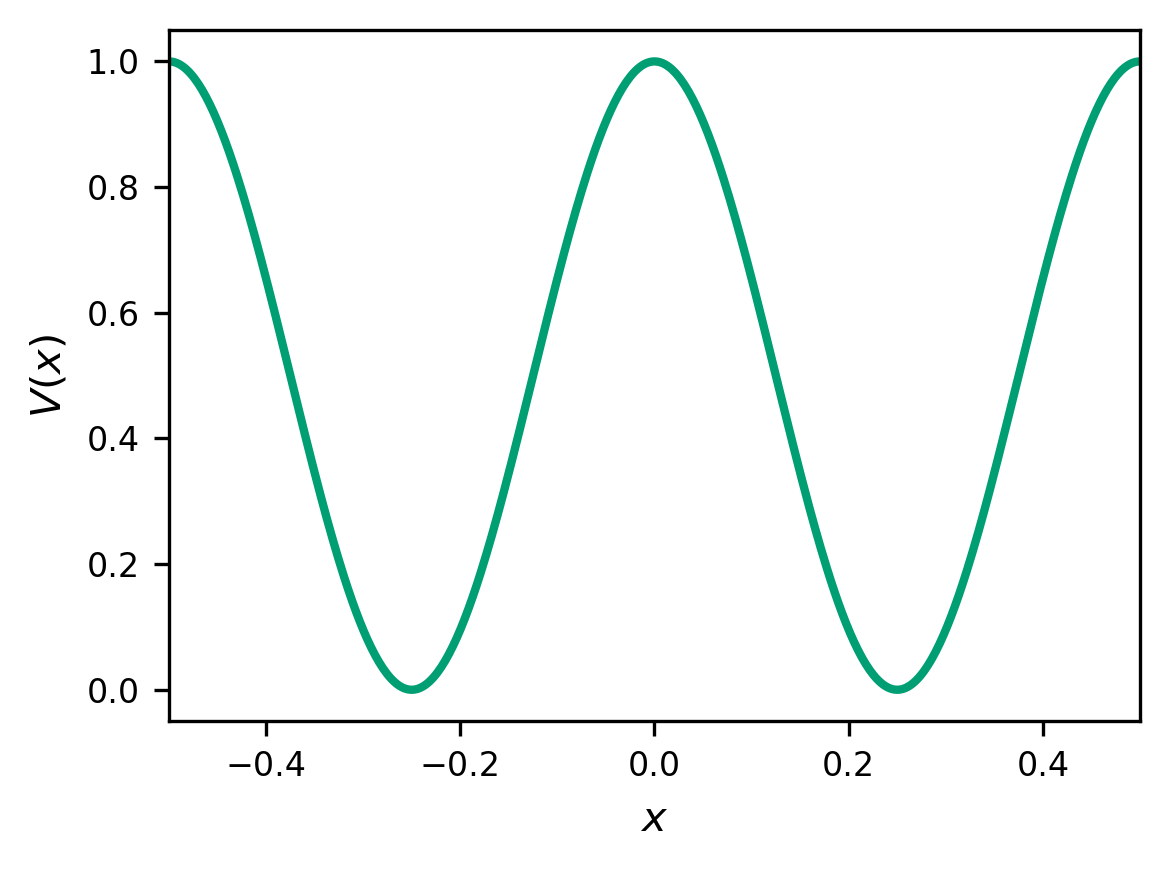

In [236]:
x = np.linspace(-x_win, x_win, 500)
zoom_out_x = (np.arange(x_res) - x_res / 2) * dx
target_barrier = Phi(x, k, amplitude = ampl, phase=np.pi/2) #* (x < 0.75/k) * (x > -0.75/k)
plt.plot(x, np.abs(target_barrier) ** 2, color=ok['green'])
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(x[0], x[-1])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Init_Potential.pdf')
plt.show()

In [237]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# New array for time
# Set
workers = 64
# Number of initial guesses per thread
init_guess_n = workers * 20


seed = np.random.default_rng(2024)
# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Phase
    seed.uniform(-2*np.pi, 2*np.pi, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 100, (init_guess_n, n))
])

freqs = 2 * np.pi * (np.array(λ_array) ** (-1))

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

print(f'Frequencies are: {freqs}')
print(f'Wavelengths are: {λ_array}')

# Define the constraints
phase_lims = (-2 * np.pi, 2 * np.pi)           # Time delay constrained to be positive
ampl_lims = (0, 1e6)      # Some constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # Phase limits
    np.full((n, 2), phase_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])

initial_guess_alt = np.hstack([
    # Phase
    seed.uniform(1, 20, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

# Define the constraints
ai_lims = (0, None)
bi_lims = (0, None)


# Create the array of bounds for the best fit minimization
bnds_alt = np.concatenate([
    # Phase limits
    np.full((n, 2), ai_lims),
    # Amplitude limits
    np.full((n, 2), bi_lims)
])


Number of Pulses: 4
Length of x: 1280
Frequencies are: [3.14159265 3.11048778 3.0799928  3.05008995]
Wavelengths are: [2.0, 2.02, 2.04, 2.06]


In [238]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(f):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(f), 2)
    assert res == 0
    phases = f[:length]
    amplitudes = f[length:(2 * length)]
    
    return phases, amplitudes

def phi_func(f, t):
    phase, amplitude = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi(t, i, j, k) for i, j, k in zip(freqs, phase, amplitude))

def obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



def phi_func_alt(f, t):
    ai, bi = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi_transform(t, i, j, k) for i, j, k in zip(freqs, ai, bi))

def obj_alt(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func_alt(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds_alt,
        tol=eps
    )
    return result.fun, result.x



In [239]:
def super_obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x)) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x

In [240]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    with Pool(processes=workers) as pool:
        result = pool.map(obj, initial_guess)
        result_super = pool.map(super_obj, initial_guess)
        result_alt = pool.map(obj_alt, initial_guess_alt)

Amplitudes here are: [1.8833356477251342, 1.8544936641938141, 36.57923551094706, 99.03411792950354]


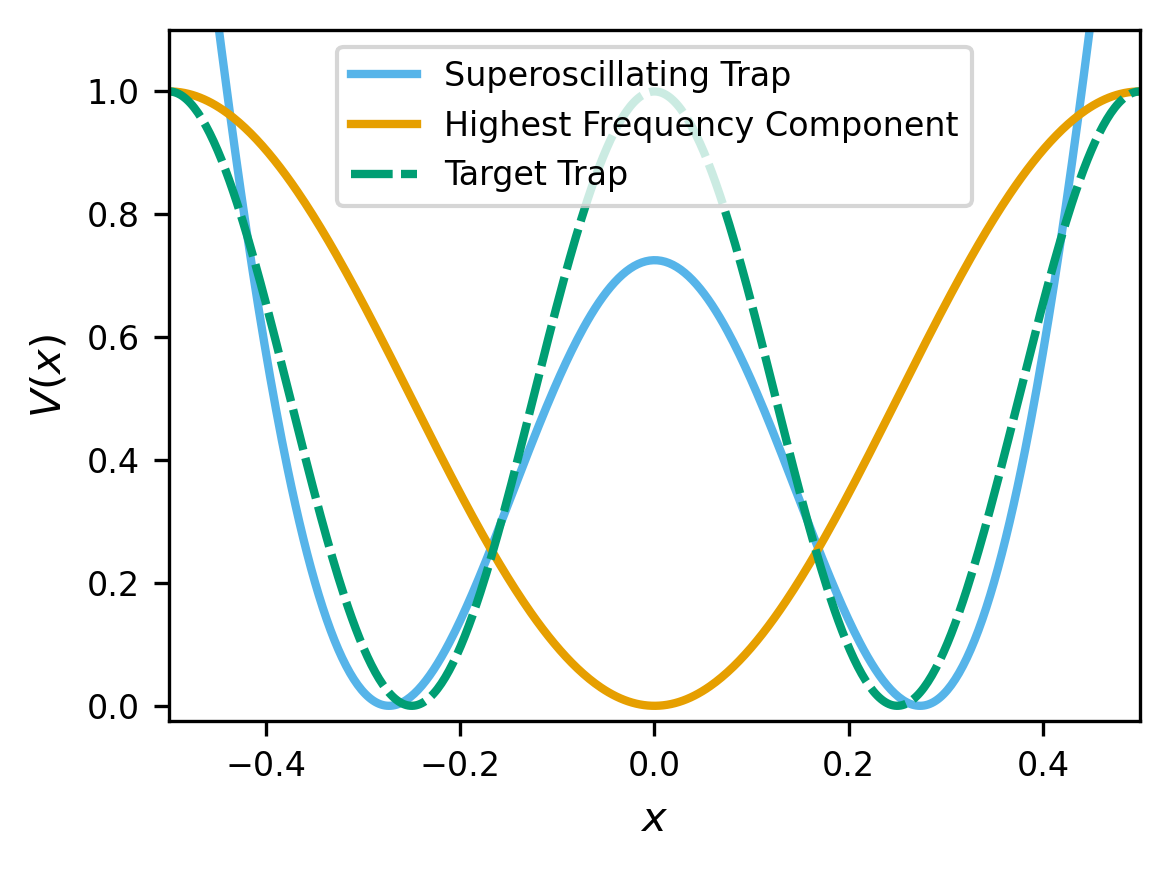

In [241]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals, x)
print(f'Amplitudes here are: {[opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]}')

plt.plot(x, np.abs(best_fit) ** 2, label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.1*ampl**2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results.pdf')
#plt.savefig('./Plots/Presentation/Results.pdf')
plt.show()

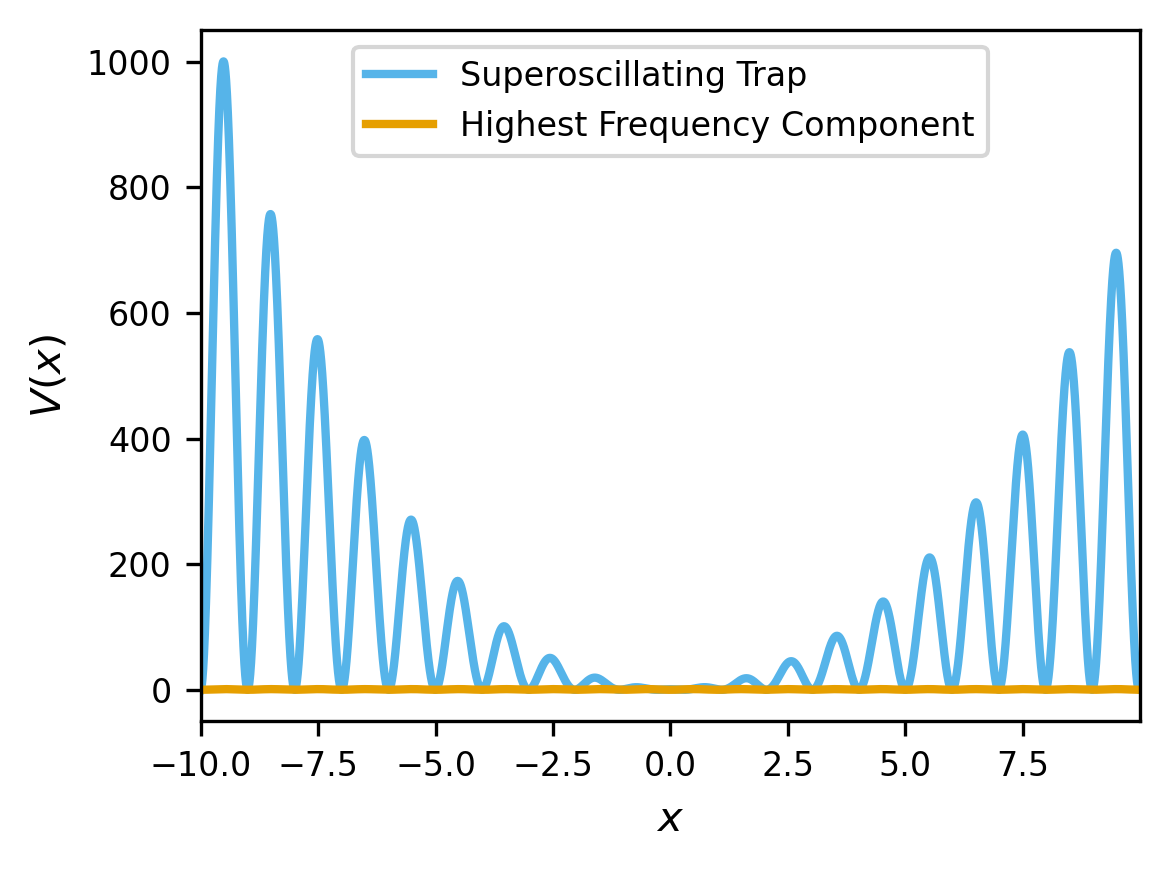

In [242]:
############################################################
#
# Show the complete potential
#
############################################################

best_fit_zoom = phi_func(opt_vals, zoom_out_x)

plt.plot(zoom_out_x, best_fit_zoom ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component')
#plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

In [ ]:
############################################################
#
# Show a limited window for suitability of the complete 
# potential
#
############################################################

plt.plot(zoom_out_x, best_fit_zoom ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component')
#plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

Amplitudes here are: [0.0, 0.0, 0.0, 0.0]


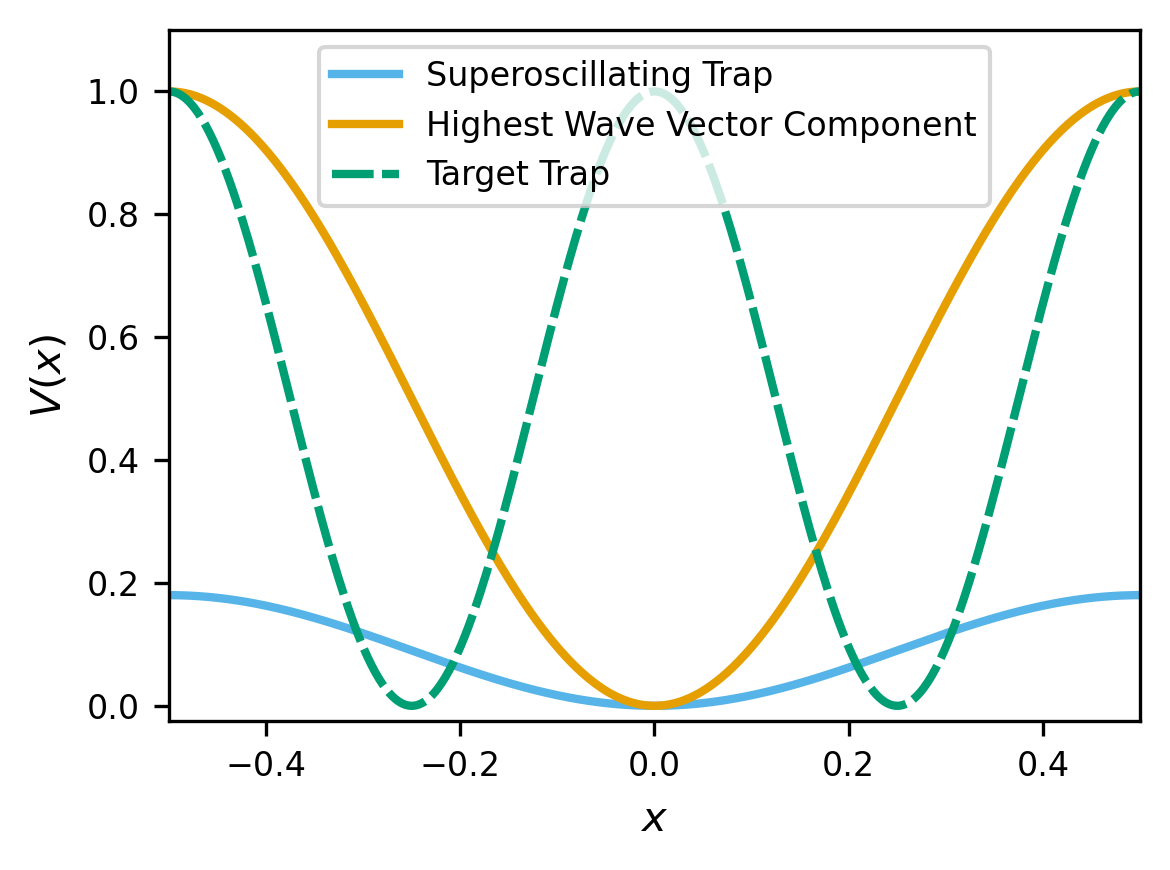

In [243]:
############################################################################
#
# Get the best result for minimization of the alternative objective function
#
############################################################################

result_alt.sort(key=lambda _: _[0])
opt_vals_alt = result_alt[0][1]
best_fit_alt = phi_func(opt_vals_alt, x)
best_fit_alt_zoom = phi_func(opt_vals_alt, zoom_out_x)
print(f'Amplitudes here are: {[opt_vals_alt[_] for _ in np.arange(1, 2 * n, 2)]}')

plt.plot(x, np.abs(best_fit_alt) ** 2, label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest Wave Vector Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.1*ampl**2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_alt.pdf')
#plt.savefig('./Plots/Presentation/Results_alt.pdf')
plt.show()

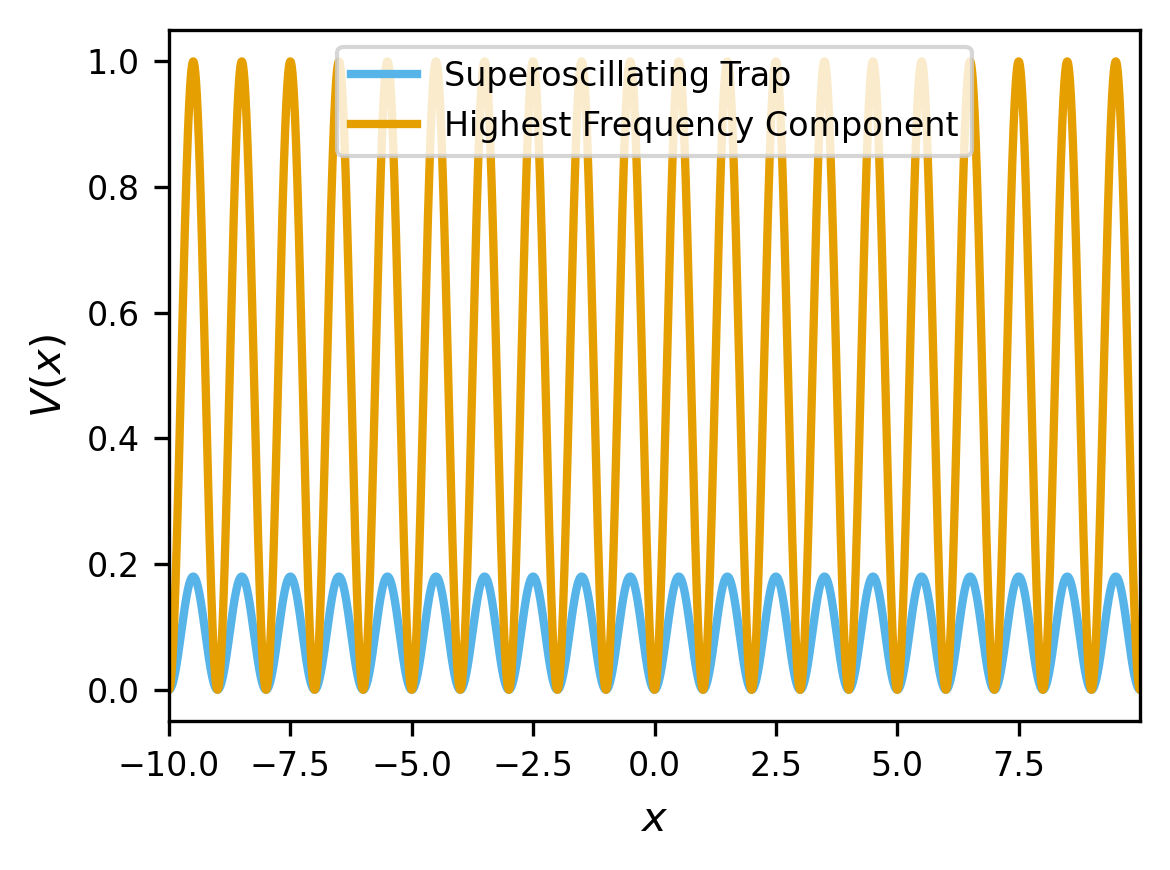

In [244]:
############################################################
#
# Show the full potential
#
############################################################


plt.plot(zoom_out_x, best_fit_alt_zoom ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component')
#plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_alt_Zoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

In [245]:
#########################################################################
#
# Fitting the fields by linear model, as it can be convexly solved
#
#########################################################################
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(zoom_out_x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

#model = linear_model.Lasso(alpha=0.0001, fit_intercept=False, tol=1e-6, max_iter=100000)
#model = linear_model.Ridge(fit_intercept=False, tol=1e-6, max_iter=100000)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(fields, target_barrier)

linear_optimized_fields = fields @ model.coef_
lo_fields_zoom = fields_zoomed @ model.coef_

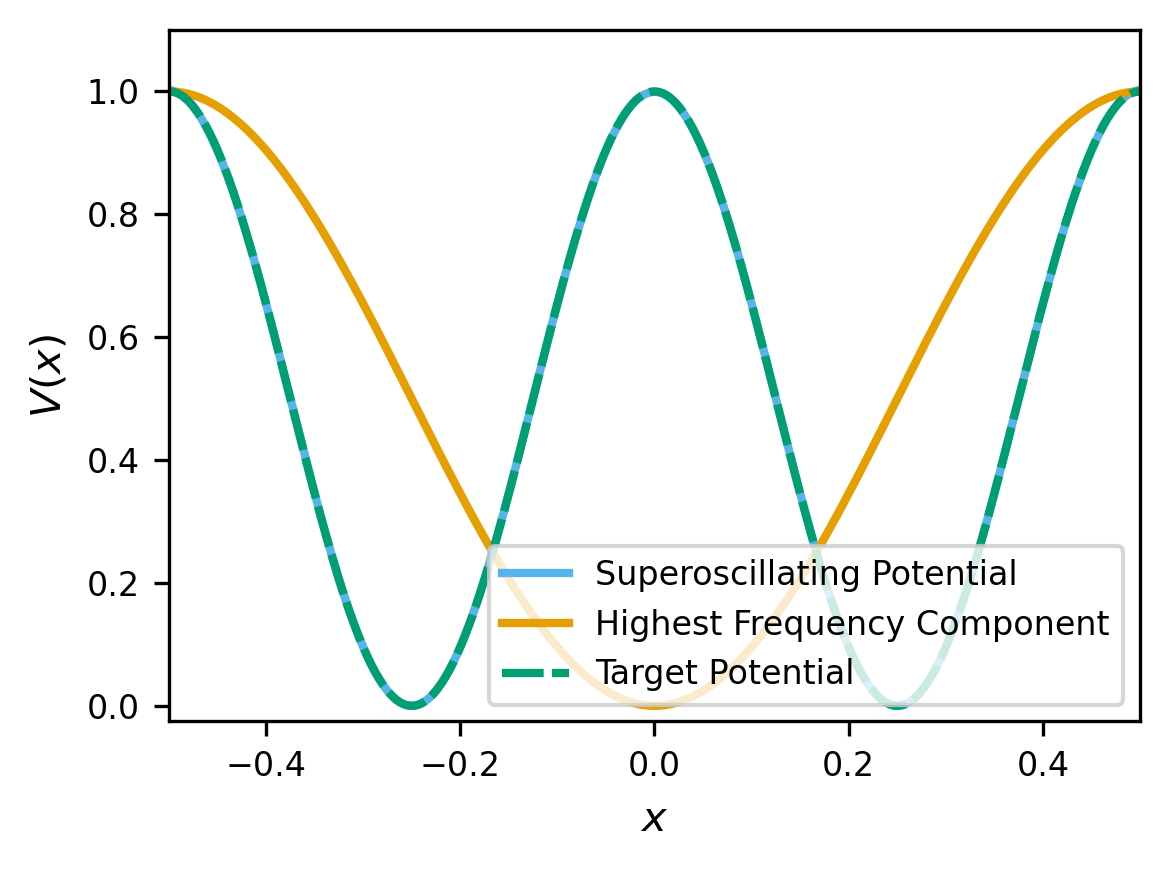

In [246]:
############################################################################
#
# Plot the results for linear optimization
#
############################################################################


plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Superoscillating Potential')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.1*ampl**2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linear.pdf')
# plt.savefig('./Plots/Presentation/Results_linear.pdf')
plt.show()

Individual amplitudes are [-3.25856106e-03  4.96804372e+05  1.01674157e-02 -1.52323656e+06
 -1.05698365e-02  1.55660769e+06  3.66102935e-03 -5.30174502e+05]
Dimensionless amplitudes are [496804.37231285765, 1523236.5585452057, 1556607.68752078, 530174.5016445355]
Phases are [1.5707963333539392, -1.5707963201200204, 1.5707963335851987, -1.5707963198895674]


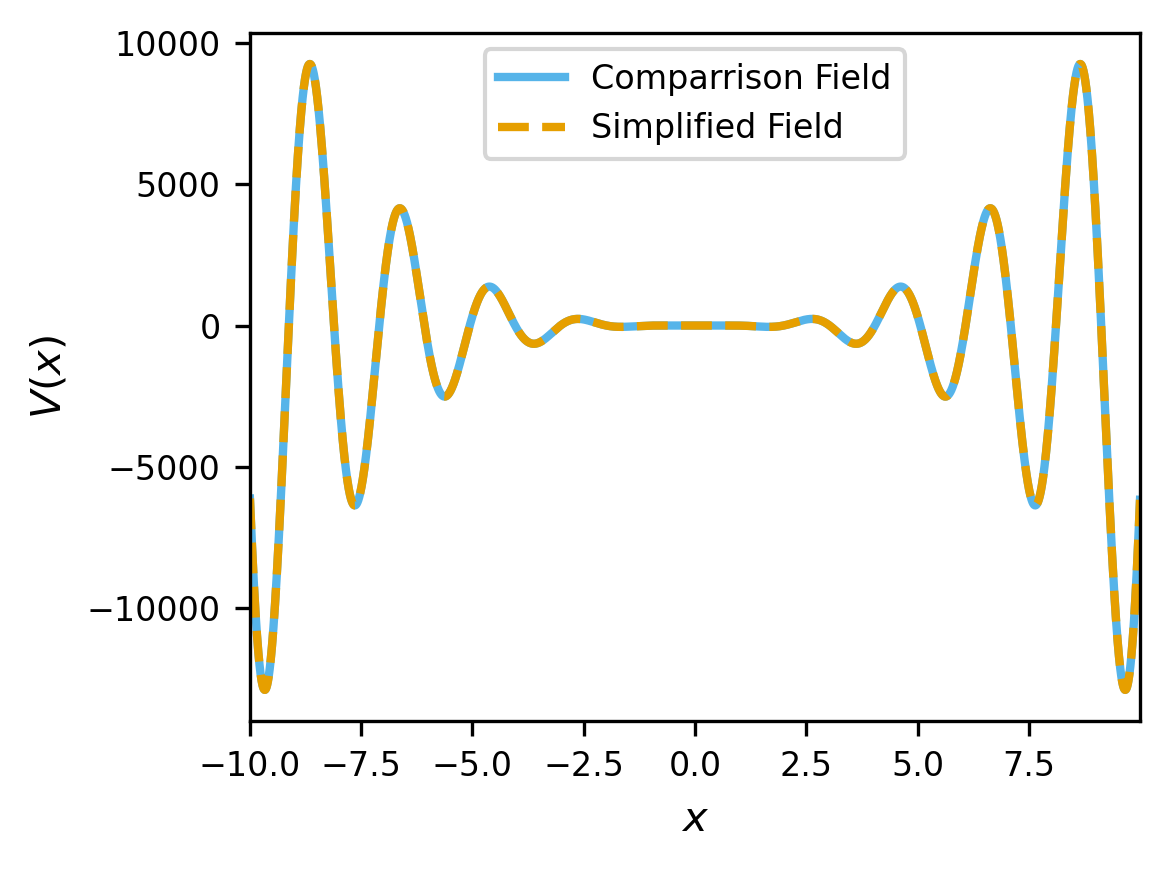

In [247]:
############################################################################
#
# Get the amplitudes of the fields used to see if they are realistic
#
############################################################################

single_func_amps = [np.sqrt((model.coef_[_]) ** 2 + (model.coef_[_+1]) ** 2) for _ in np.arange(0, len(model.coef_), 2)]
single_func_phase = [np.pi/2-np.angle(model.coef_[_ + 1] + 1j * model.coef_[_]) for _ in np.arange(0, len(model.coef_), 2)]
simplified_fields = [Phi(zoom_out_x, freqs[_], phase=single_func_phase[_], amplitude= single_func_amps[_]) for _ in range(len(freqs))]
print(f'Individual amplitudes are {model.coef_}')
print(f'Dimensionless amplitudes are {single_func_amps}')
print(f'Phases are {single_func_phase}')

plt.plot(zoom_out_x, lo_fields_zoom, label='Comparrison Field')
plt.plot(zoom_out_x, np.sum(simplified_fields, axis=0), '--', label='Simplified Field')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()


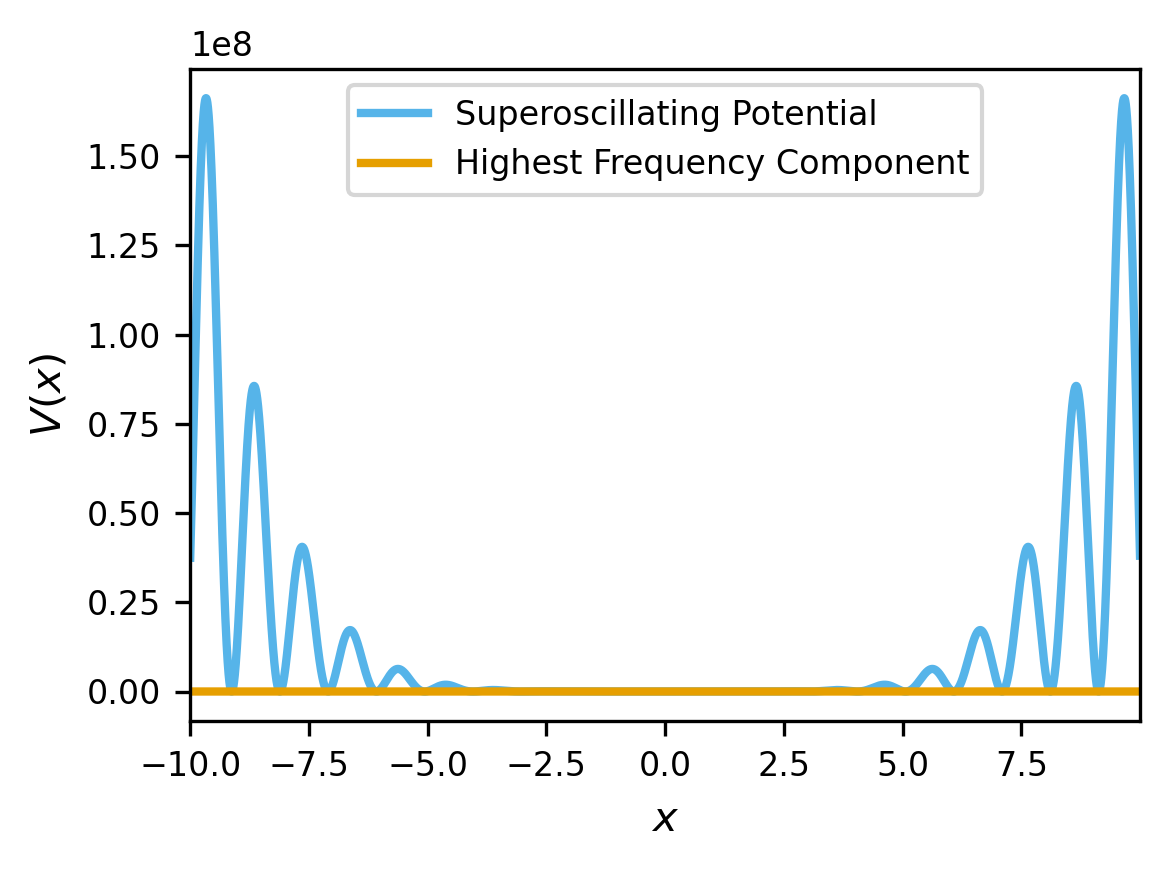

In [255]:
############################################################################
#
# Plot the zoom out of the results for linear optimization
#
############################################################################


plt.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Superoscillating Potential')
plt.plot(zoom_out_x, np.abs(Phi(zoom_out_x, k_max, amplitude=ampl)) ** 2, label='Highest Frequency Component')
#plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linearZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

In [249]:
def get_local_freq(field, time):
    phase = np.unwrap(np.angle(hilbert(field)))
    return np.gradient(phase, np.pi / (time.max() - time.min()))


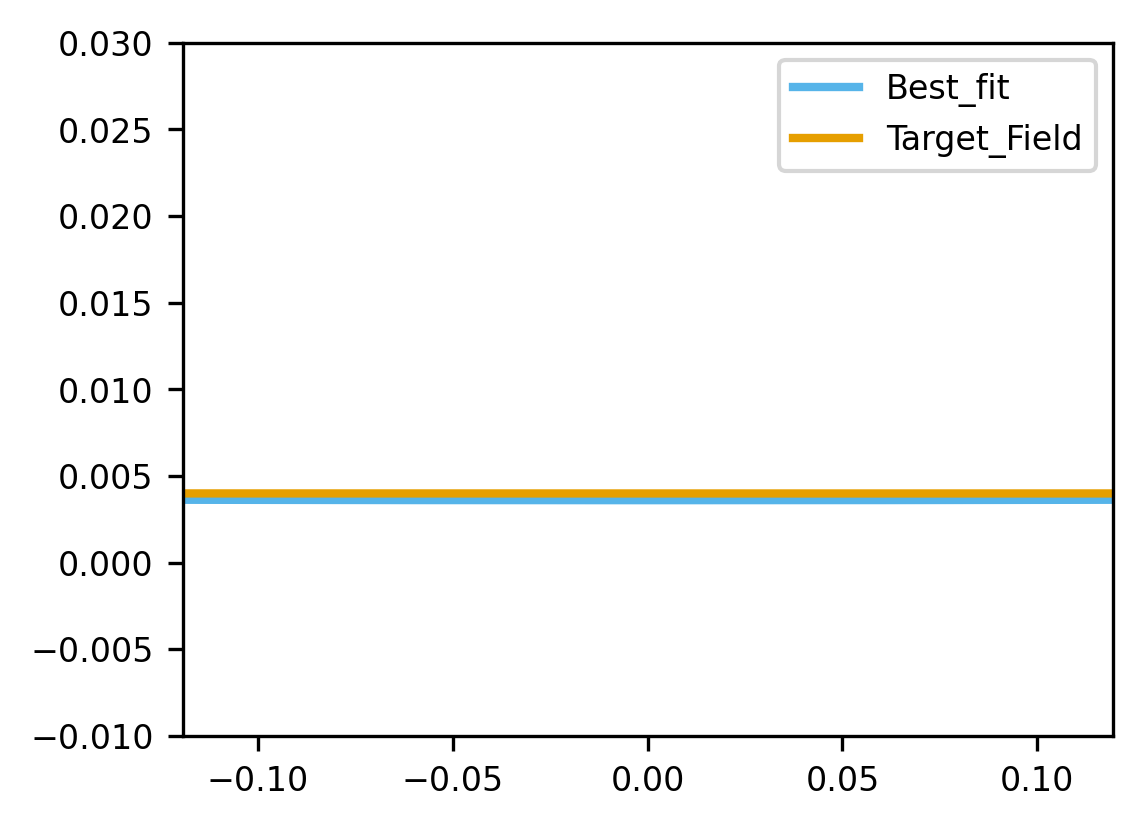

In [250]:
trim_edges=1
cut= slice(trim_edges,-trim_edges)
best_fit_lf = get_local_freq(best_fit[cut], x[cut])
target_lf = get_local_freq(target_barrier[cut], x[cut])
plt.plot(x[cut], best_fit_lf, label='Best_fit')
plt.plot(x[cut], target_lf, label='Target_Field')
plt.xlim(-0.75/k, 0.75/k)
plt.ylim(-0.01, 0.03)
plt.legend()
plt.show()


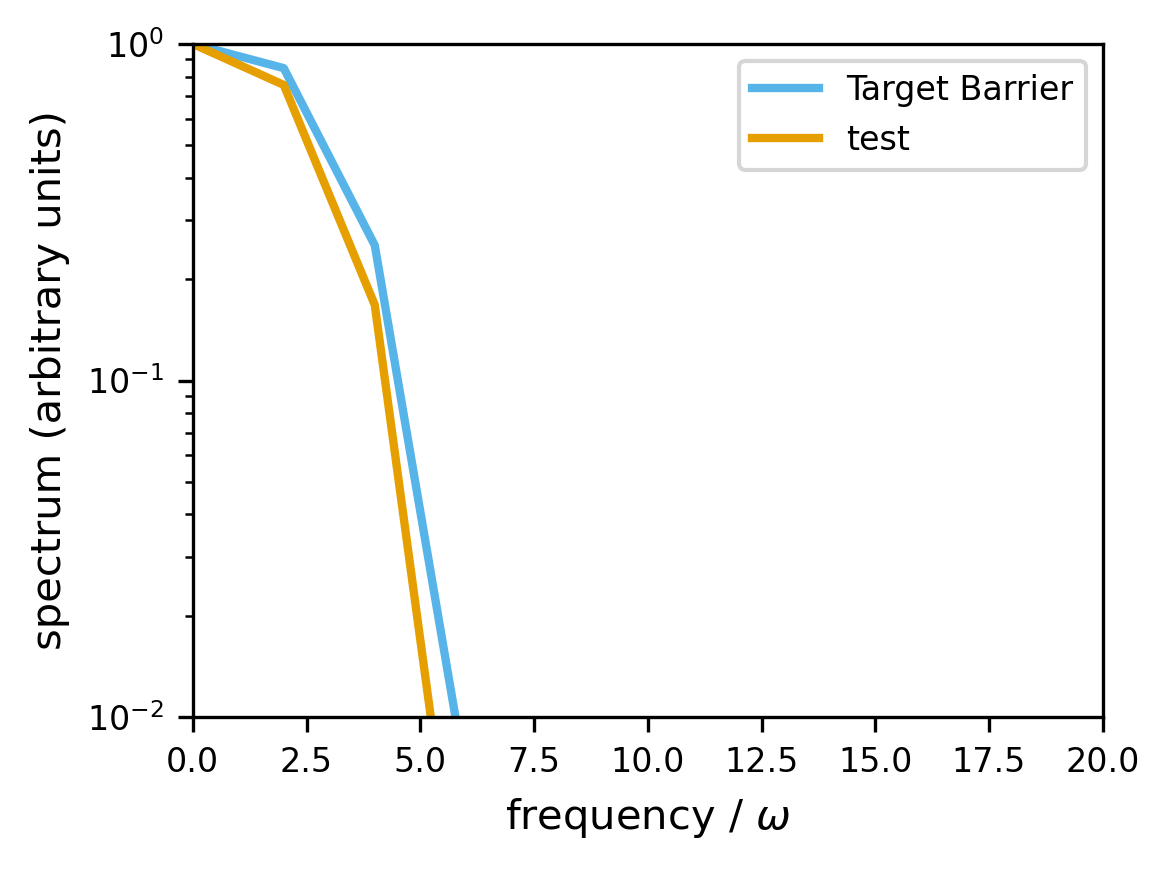

In [251]:
def plot_spectrum(f, t, **kwargs):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(f)
    K = np.arange(N)

    # frequency range
    omegas = (K - N / 2) * np.pi / (0.5 * t.max())

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** K * blackman(N) * f)
    ) ** 2
    spectrum /= spectrum.max()
    plt.semilogy(omegas / k, spectrum, **kwargs, label=get)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel(r'frequency / $\omega$')
    plt.xlim([0, 20])
    plt.ylim([1e-2, 1.])

plt.figure()
get = 'Target Barrier'
plot_spectrum(target_barrier, x)
get = 'test'
plot_spectrum(best_fit, x)


plt.legend()
plt.tight_layout()
plt.show()


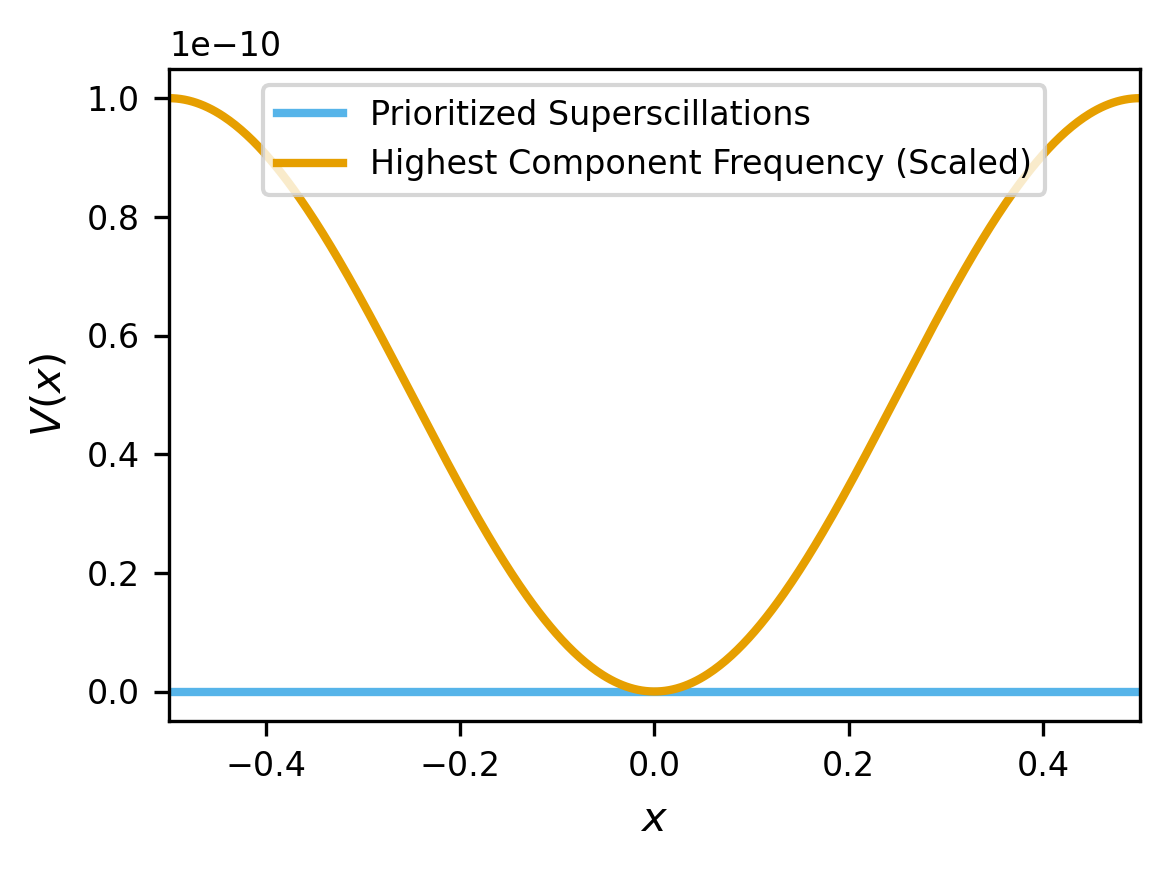

In [252]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result_super.sort(key=lambda _: _[0])
opt_vals = result_super[0][1]
best_fit_super = phi_func(opt_vals, x)

plt.plot(x, phi_func(opt_vals, x) ** 2, label='Prioritized Superscillations')
plt.plot(x, (Phi(x, k_max) ** 2) * 1e-10, label='Highest Component Frequency (Scaled)')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(x[0], x[-1])
plt.legend()
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Superoscillations.pdf')
#plt.savefig('./Plots/Presentation/Superoscillations.pdf')
plt.show()


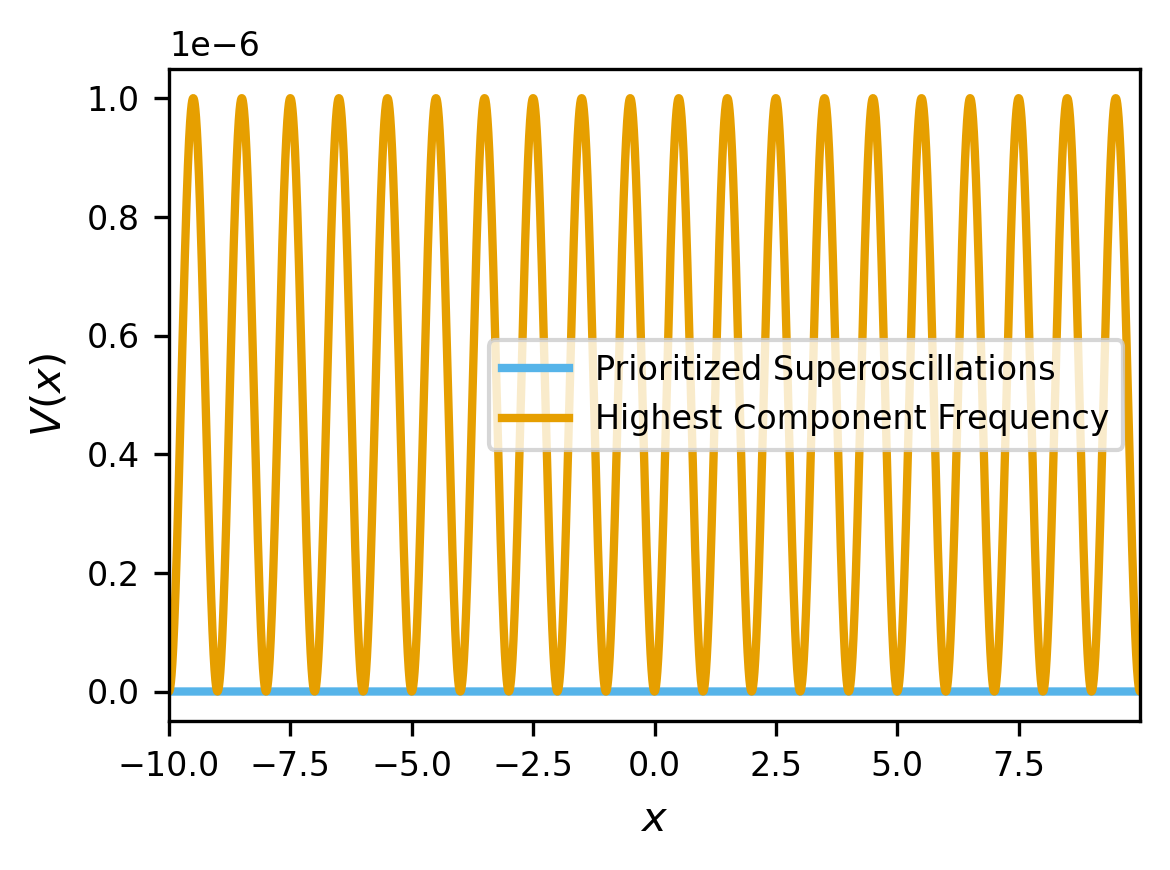

In [253]:
plt.plot(zoom_out_x, phi_func(opt_vals, zoom_out_x) ** 2, label='Prioritized Superoscillations')
plt.plot(zoom_out_x, Phi(zoom_out_x, k_max) ** 2 * 1e-6, label='Highest Component Frequency')
#plt.plot(x, target_barrier, label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.legend()
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_SuperoscillationsZoomed.pdf')
#plt.savefig('./Plots/Presentation/SuperoscillationsZoomed.pdf')
plt.show()


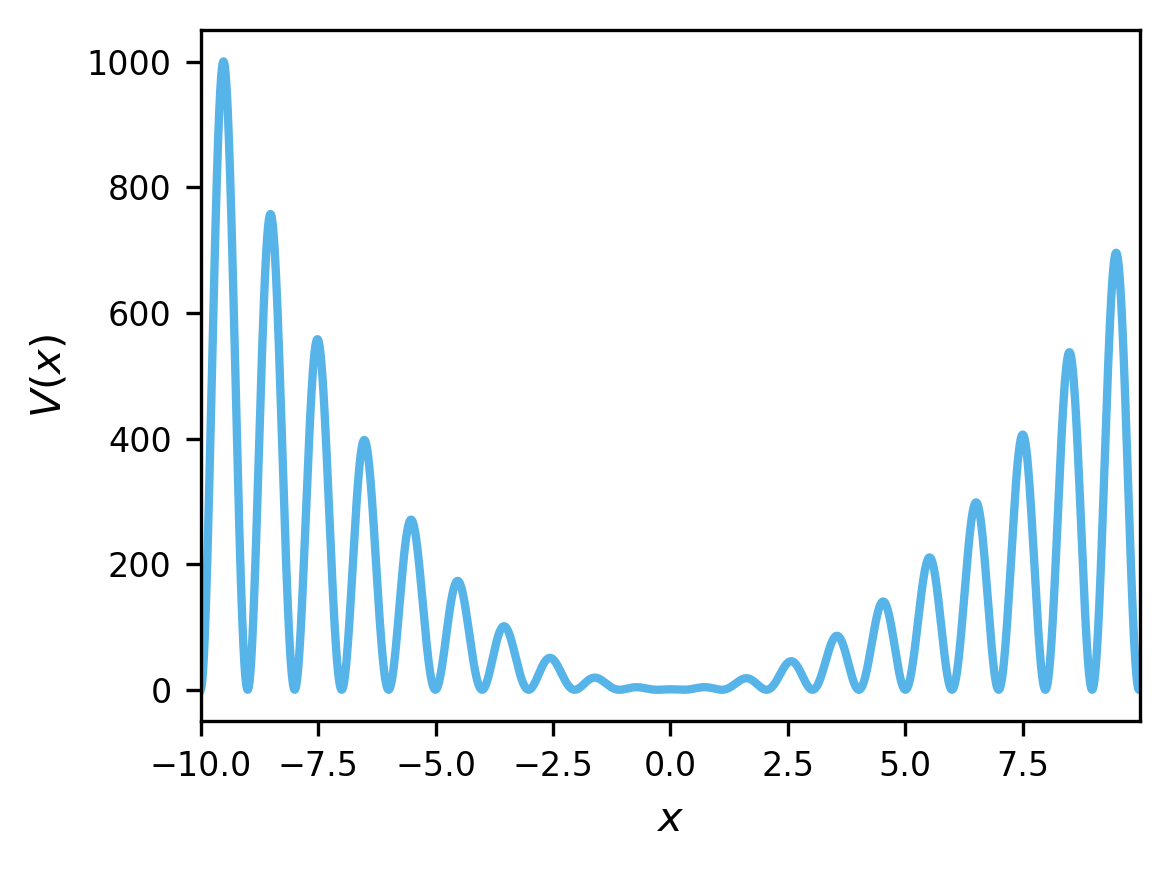

In [257]:
########################################################################################################################
# Get the BEC
########################################################################################################################

dz = dx
# generate coordinate range
z = zoom_out_x
T = 25
times = np.linspace(0, T, 500)

@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope = 0 # 1 / (2 * np.pi)
suggestion_sin = Phi(z, np.pi / (2 * x_lim), amplitude=2*ampl) ** 2


sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=UnivariateSpline(z, (np.abs(best_fit_zoom) ** 2), s=0),
    #initial_trap=UnivariateSpline(z, (np.abs(lo_fields_zoom) ** 2), s=0),
    #initial_trap=UnivariateSpline(z, (np.abs(lo_fields_zoom) ** 2 + suggestion_sin), s=0),
    #initial_trap=UnivariateSpline(z, (np.abs(lo_fields_zoom) ** 2 + (suggestion_slope * z) ** 2), s=0),
    times=times,
    diff_k=diff_k,
)

plt.plot(z, sys_params['initial_trap'](z))
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(z[0], z[-1])
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential.pdf')
plt.show()

In [258]:
init_state, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    dt=1e-3,
    epsilon=1e-8,
    **sys_params
)

init_state, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-5,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial State Chemical Potential: {gpe.convert_energy(mu, -9)} nK')


Starting imaginary time propagation
current ground state energy = 1.9801e+02


Final current ground state energy = 5.1683e+01

Starting imaginary time propagation
current ground state energy = 5.1683e+01
current ground state energy = 5.1677e+01
current ground state energy = 5.1677e+01


Final current ground state energy = 5.1677e+01
Initial State Chemical Potential: 124.0051963527721 nK


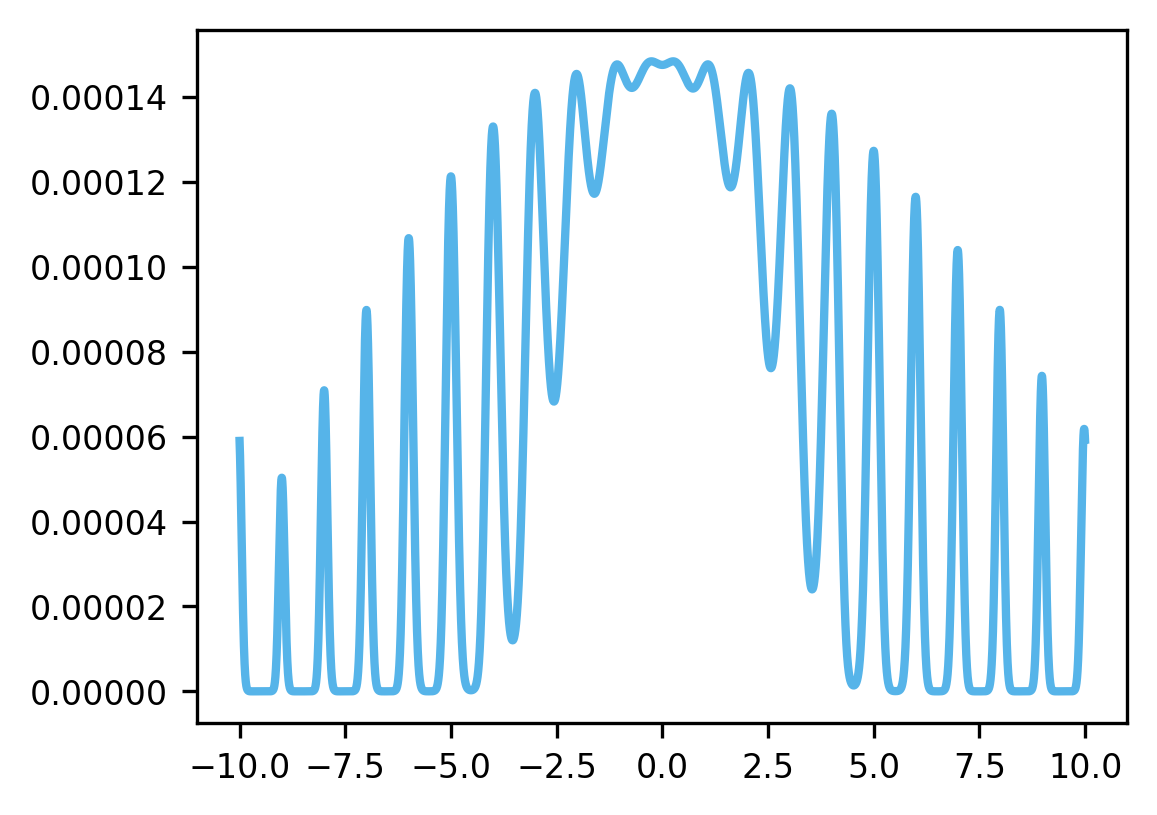

Sanity Check, the density is: 1.0


In [259]:
density = np.abs(init_state) ** 2 * dz
plt.plot(z, density)
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

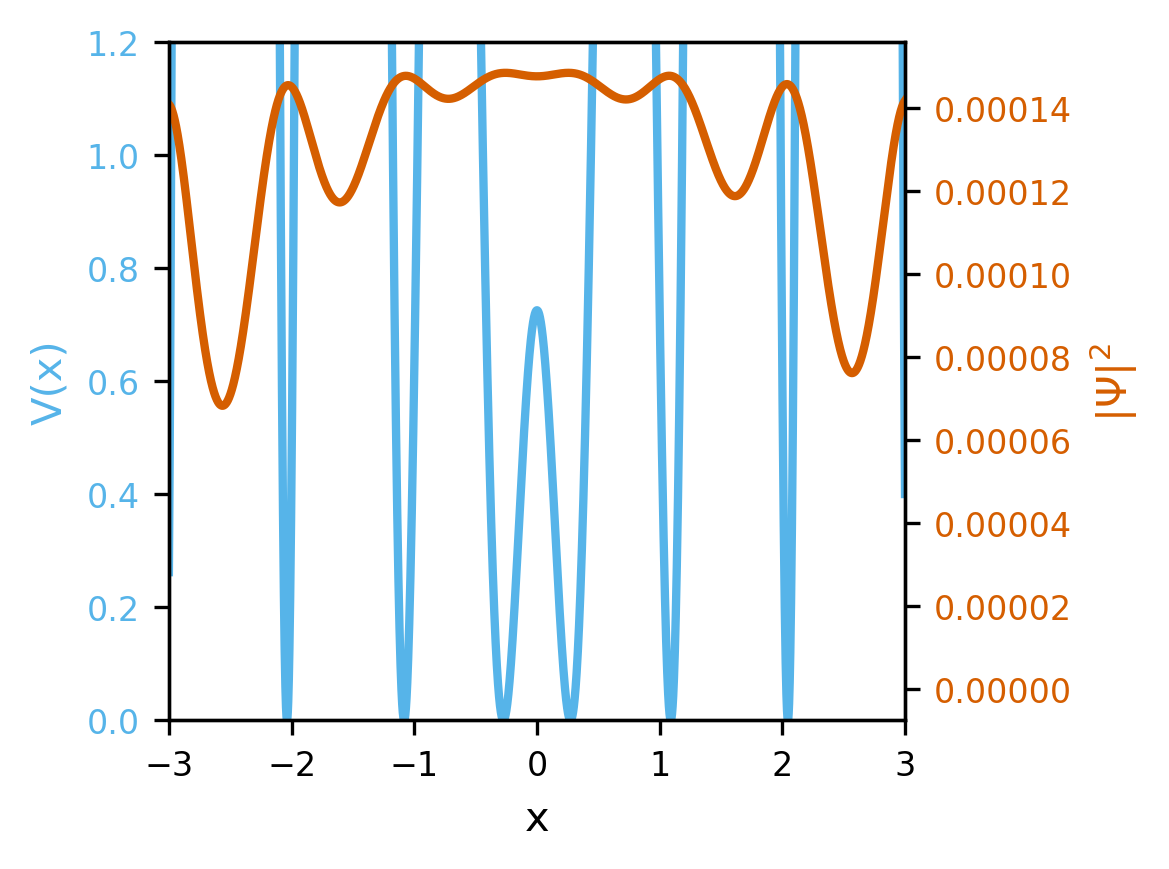

In [263]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, 1.2*ampl**2)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential.pdf')
plt.show()


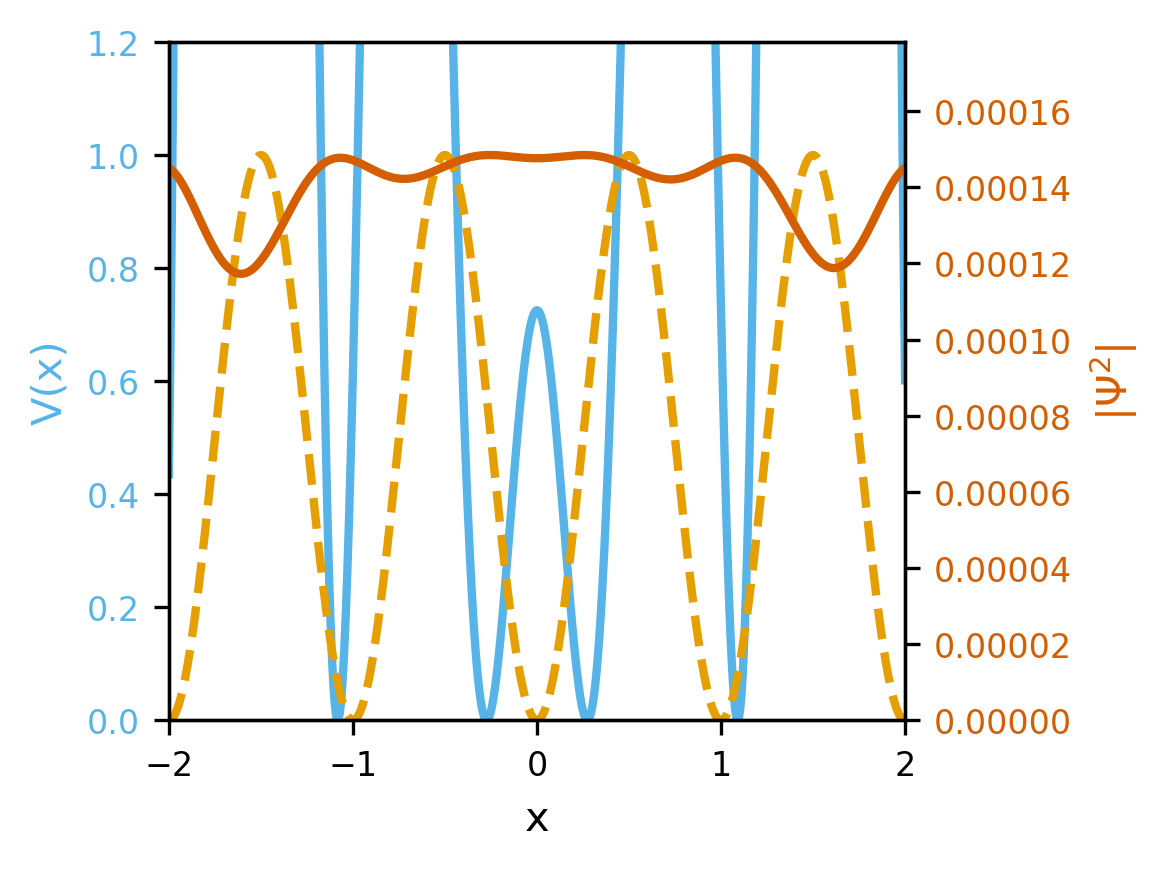

In [262]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])
ax1.set_xlabel('x')
ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, 1.2*ampl**2)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped.pdf')
#plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped.png')
plt.show()

In [73]:
density_func = UnivariateSpline(z, density, s=0)
n_peaks = 2
peak_spacing = 2 * λ / n_peaks
peaks_sectioning = np.linspace(-λ, -λ+(n_peaks-1)*peak_spacing, n_peaks)


interest_areas = [(np.array(z)[(z>=_) & (z<(_+peak_spacing))]) for _ in peaks_sectioning]
peak_locations = [_[density_func(_).argmax()] for _ in interest_areas]
confinement_distance = [np.abs(peak_locations[_+1]-peak_locations[_]) for _ in range(len(peak_locations)-1)]
print(f'Peaks are located at: {peak_locations}')
print(f'Distances between these peaks are: {confinement_distance}')


Peaks are located at: [-1.5800002115222105, 1.5800002115222105]
Distances between these peaks are: [3.160000423044421]


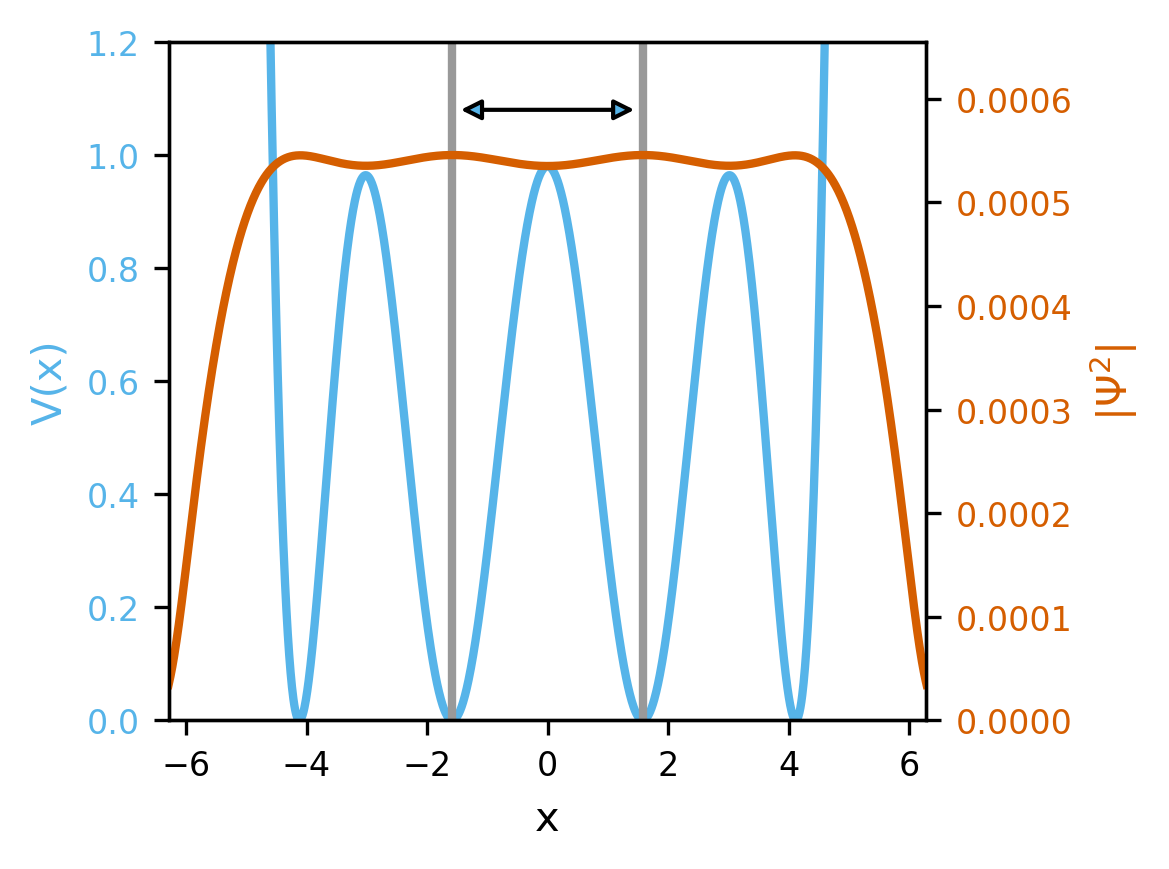

In [74]:
plot_max = 1.2*ampl**2    

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])
ax1.vlines(peak_locations, 0, plot_max, color=ok['grey'])
for _ in range(n_peaks-1):
    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=10))
ax1.set_xlabel('x')
ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo.pdf')
plt.show()

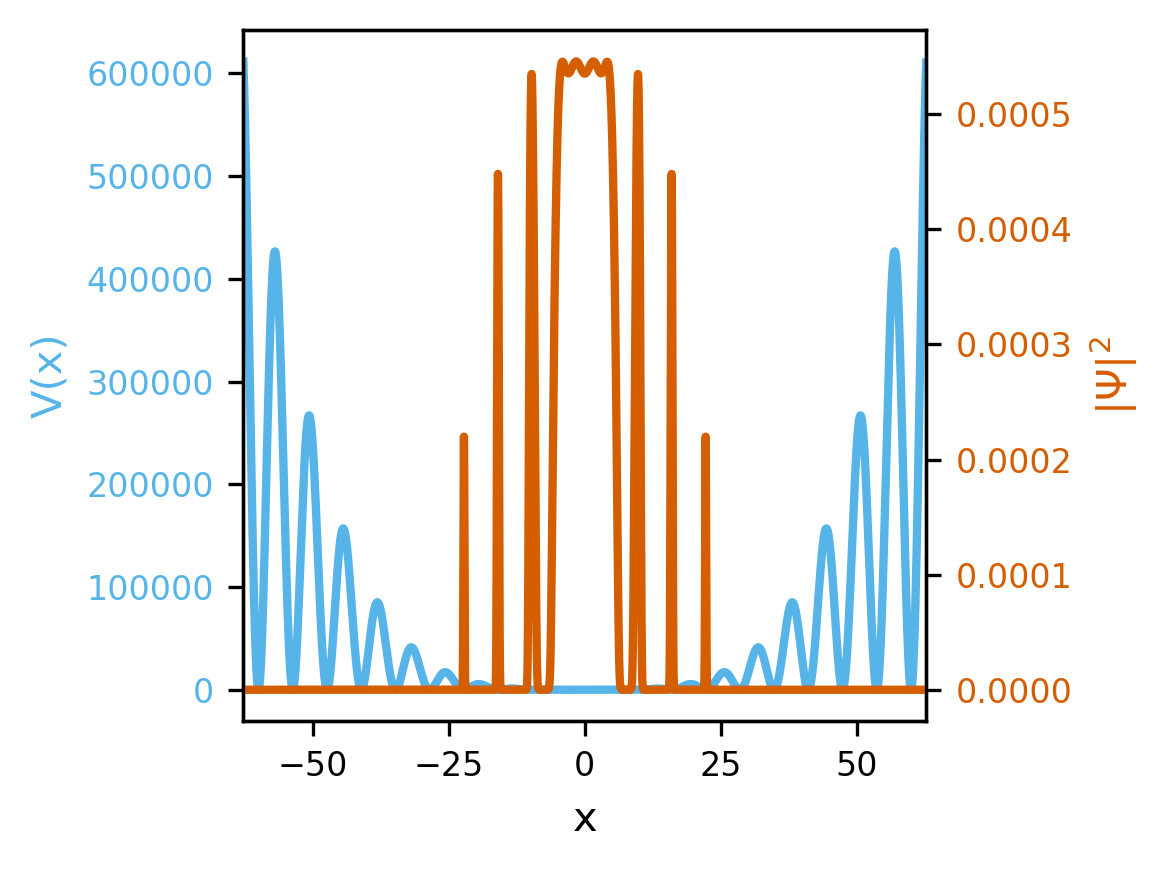

In [75]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential.pdf')
plt.show()

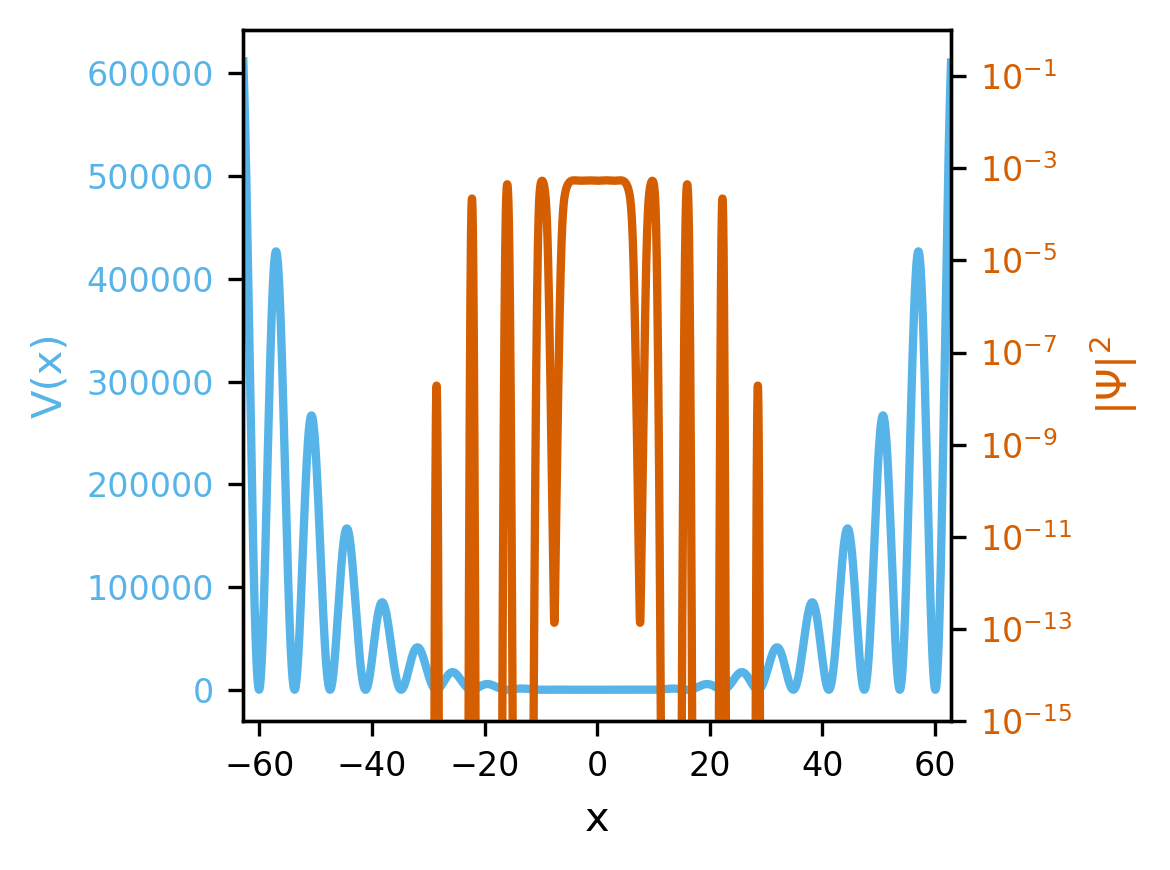

In [76]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.semilogy(z, density, color=ok['red'])
ax2.set_ylim(10**-15, 1)
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_semilogy.pdf')
plt.show()

In [77]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The confinement limit is half the wavelength: {0.5 * λ_min}')

The variance is 40.05357729352393
The confinement limit is half the wavelength: 6.283185307179586


In [78]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The confinement limit is the already halved wavelength: {λ_min}')

The variance is 40.05357729352393
The confinement limit is the already halved wavelength: 12.566370614359172


In [79]:
print(f' wavelengths are : {[np.round(gpe.convert_x(_,-9), 2) for _ in λ_array]} nm')

 wavelengths are : [19165.3, 19261.13, 19356.95] nm
